✅ Catálogo K2 carregado: 4004 linhas.
✅ Catálogo Kepler carregado: 9564 linhas.
✅ Catálogo TESS carregado: 7703 linhas.

--- Limpeza de Dados e Tratamento de NaN ---
Linhas removidas por NaN em features chave: 4990 (21271 -> 16281)
Linhas removidas (Outliers cumulativos): 5022 (16281 -> 11259)

--- Correlação no Dataset Mestre Limpo ---
Correlação das features com a classificação (TARGET):
period                  0.225089
transit_duration_hrs    0.051724
transit_depth_ppm       0.026487
star_radius_sol        -0.120976
planet_radius_earth    -0.122097
star_teff              -0.133633
Name: target_encoded, dtype: float64


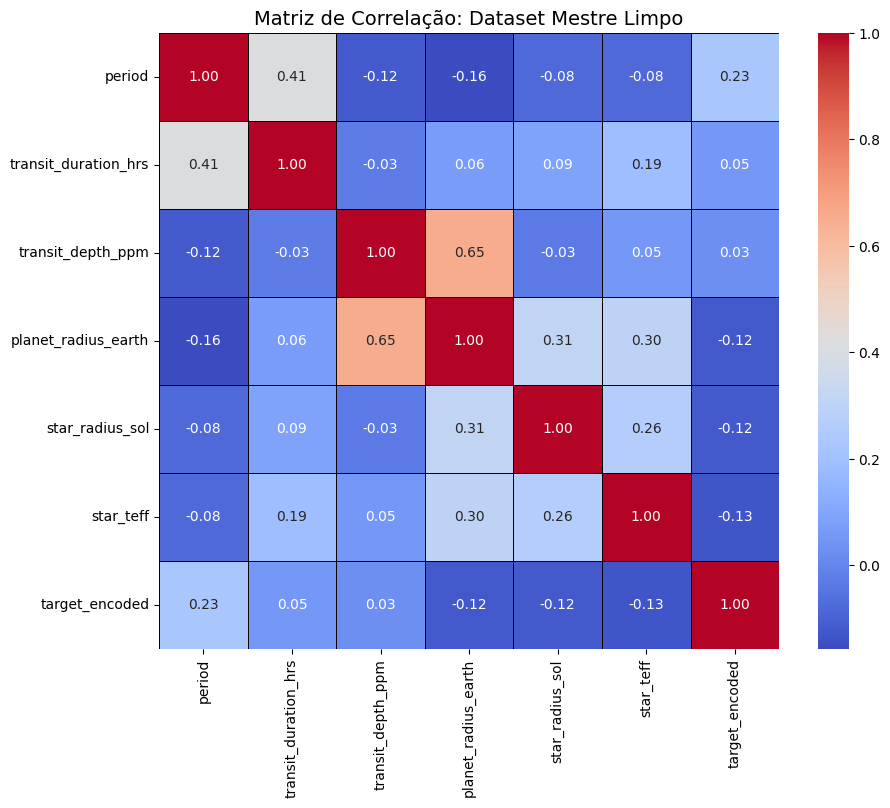


--- Dataset Mestre FINALIZADO ---
Total de Registros Combinados e Limpos: 11259 linhas.
✅ Arquivo salvo: master_clean_for_correlation.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

FILE_CATALOG = 'k2pandc_2025.10.03_15.51.12.csv'
FILE_CUMULATIVE = 'cumulative_2025.10.03_16.08.03.csv'
FILE_TOI = 'TOI_2025.10.03_16.04.34.csv'

READ_PARAMS_CATALOG = {'sep': ',', 'skiprows': 98, 'engine': 'python', 'encoding': 'latin-1'}
READ_PARAMS_KEPLER = {'sep': ',', 'skiprows': 53, 'engine': 'python', 'encoding': 'latin-1'}
READ_PARAMS_TESS = {'sep': ',', 'skiprows': 69, 'engine': 'python', 'encoding': 'latin-1'}

dfs = []

COLUMNS_TO_KEEP = [
    'period', 'transit_epoch_bjd', 'transit_duration_hrs', 'transit_depth_ppm',
    'planet_radius_earth', 'star_radius_sol', 'star_teff', 'star_logg',
    'disposition_text', 'source'
]

try:
    df_cat = pd.read_csv(FILE_CATALOG, **READ_PARAMS_CATALOG)
    df_cat['source'] = 'K2'

    df_cat['transit_depth_ppm'] = np.nan
    df_cat['transit_epoch_bjd'] = np.nan
    df_cat['transit_duration_hrs'] = np.nan

    df_cat = df_cat.rename(columns={
        'pl_orbper': 'period', 'pl_rade': 'planet_radius_earth', 'st_rad': 'star_radius_sol',
        'st_teff': 'star_teff', 'st_logg': 'star_logg', 'disposition': 'disposition_text'
    })
    df_cat = df_cat[[col for col in COLUMNS_TO_KEEP if col in df_cat.columns]].copy()
    dfs.append(df_cat)
    print(f"Catálogo K2 carregado: {len(df_cat)} linhas.")
except Exception as e:
    print(f" Falha ao carregar o Catálogo K2: {e}")


try:
    df_kepler = pd.read_csv(FILE_CUMULATIVE, **READ_PARAMS_KEPLER)
    df_kepler['source'] = 'Kepler'
    df_kepler = df_kepler.rename(columns={
        'koi_period': 'period', 'koi_time0bk': 'transit_epoch_bjd', 'koi_duration': 'transit_duration_hrs',
        'koi_depth': 'transit_depth_ppm', 'koi_prad': 'planet_radius_earth', 'koi_srad': 'star_radius_sol',
        'koi_steff': 'star_teff', 'koi_slogg': 'star_logg', 'koi_disposition': 'disposition_text'
    })
    df_kepler = df_kepler[[col for col in COLUMNS_TO_KEEP if col in df_kepler.columns]].copy()
    dfs.append(df_kepler)
    print(f" Catálogo Kepler carregado: {len(df_kepler)} linhas.")
except Exception as e:
    print(f" Falha ao carregar o Catálogo Kepler: {e}")

try:
    df_tess = pd.read_csv(FILE_TOI, **READ_PARAMS_TESS)
    df_tess['source'] = 'TESS'
    df_tess = df_tess.rename(columns={
        'pl_orbper': 'period', 'pl_tranmid': 'transit_epoch_bjd', 'pl_trandurh': 'transit_duration_hrs',
        'pl_trandep': 'transit_depth_ppm', 'pl_rade': 'planet_radius_earth', 'st_rad': 'star_radius_sol',
        'st_teff': 'star_teff', 'st_logg': 'star_logg', 'tfopwg_disp': 'disposition_text'
    })
    df_tess = df_tess[[col for col in COLUMNS_TO_KEEP if col in df_tess.columns]].copy()
    dfs.append(df_tess)
    print(f"✅ Catálogo TESS carregado: {len(df_tess)} linhas.")
except Exception as e:
    print(f"❌ Falha ao carregar o Catálogo TESS: {e}")

if not dfs:
    print("\n❌ ERRO: Nenhum dataset foi carregado com sucesso. Verifique os nomes e permissões.")
else:
    df_master = pd.concat(dfs, ignore_index=True)

    target_labels = ['CONFIRMED', 'CANDIDATE', 'PC', 'CP', 'PUBLISHED CONFIRMED']
    df_master['target_encoded'] = df_master['disposition_text'].apply(
        lambda x: 1 if pd.notna(x) and x.upper() in [l.upper() for l in target_labels] else 0
    )

    core_features = ['period', 'planet_radius_earth', 'transit_depth_ppm', 'star_teff']
    initial_master_rows = len(df_master)
    df_master_clean = df_master.dropna(subset=core_features).copy()
    dropped_nan_rows = initial_master_rows - len(df_master_clean)

    print(f"\n--- Limpeza de Dados e Tratamento de NaN ---")
    print(f"Linhas removidas por NaN em features chave: {dropped_nan_rows} ({initial_master_rows} -> {len(df_master_clean)})")

    df_clean_outliers = df_master_clean.copy()
    outlier_features = ['period', 'transit_duration_hrs', 'transit_depth_ppm', 'planet_radius_earth']

    initial_rows_after_nan = len(df_clean_outliers)
    for col in outlier_features:
        if col in df_clean_outliers.columns and pd.api.types.is_numeric_dtype(df_clean_outliers[col]):
            Q1 = df_clean_outliers[col].quantile(0.25)
            Q3 = df_clean_outliers[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_clean_outliers = df_clean_outliers[
                ((df_clean_outliers[col] >= lower_bound) & (df_clean_outliers[col] <= upper_bound))
            ]

    dropped_outlier_rows = initial_rows_after_nan - len(df_clean_outliers)
    df_master_final = df_clean_outliers

    print(f"Linhas removidas (Outliers cumulativos): {dropped_outlier_rows} ({initial_rows_after_nan} -> {len(df_master_final)})")

    corr_features = ['period', 'transit_duration_hrs', 'transit_depth_ppm',
                     'planet_radius_earth', 'star_radius_sol', 'star_teff']

    valid_corr_cols = [col for col in corr_features if col in df_master_final.columns] + ['target_encoded']

    if len(df_master_final) > 1 and len(valid_corr_cols) > 1:
        correlation_matrix = df_master_final[valid_corr_cols].corr()
        correlation_target = correlation_matrix['target_encoded'].drop('target_encoded', errors='ignore').sort_values(ascending=False)

        print(f"\n--- Correlação no Dataset Mestre Limpo ---")
        print("Correlação das features com a classificação (TARGET):")
        print(correlation_target)

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            cbar=True,
            linewidths=0.5,
            linecolor='black'
        )
        plt.title('Matriz de Correlação: Dataset Mestre Limpo', fontsize=14)
        plt.show()
    else:
        print("\nAVISO: Não foi possível calcular a correlação. O dataset ficou muito pequeno após a limpeza.")

    final_file_name = "master_clean_for_correlation.csv"
    df_master_final.to_cs    # files.download(final_file_name)v(final_file_name, index=False)

    print(f"\n--- Dataset Mestre FINALIZADO ---")
    print(f"Total de Registros Combinados e Limpos: {len(df_master_final)} linhas.")
    print(f"✅ Arquivo salvo: {final_file_name}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from google.colab import files

FILE_NAME = 'master_clean_for_correlation.csv'

try:
    df_ml = pd.read_csv(FILE_NAME)
    print(f" Dataset '{FILE_NAME}' carregado com {len(df_ml)} linhas.")
except FileNotFoundError:
    print(f" ERRO: Arquivo '{FILE_NAME}' não encontrado. Certifique-se de que ele está no seu ambiente Colab.")
    exit()

print("\n--- Estrutura do Dataset Antes do ML Prep ---")
df_ml.info()

df_ml = pd.get_dummies(df_ml, columns=['source'], prefix='source')

df_ml.drop(columns=['disposition_text', 'star_logg'], inplace=True)

print("\n--- One-Hot Encoding Aplicado ---")
print(f"Colunas após Encoding (total: {df_ml.shape[1]}): {list(df_ml.columns)}")

X = df_ml.drop(columns=['target_encoded'])

Y = df_ml['target_encoded']

numerical_features = X.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

print("\n--- Escalonamento Aplicado (StandardScaler) ---")
print(f"Valores médios das features numéricas após Scaling (devem ser próximos de 0):")
print(X[numerical_features].mean().head())

df_ml_ready = pd.concat([X, Y], axis=1)

FINAL_FILE_NAME = 'master_ML_READY.csv'
df_ml_ready.to_csv(FINAL_FILE_NAME, index=False)

# files.download(FINAL_FILE_NAME)
print(f"\n--- EXPORTAÇÃO FINAL PARA ML ---")
print(f"✅ Dataset pronto para Machine Learning salvo: '{FINAL_FILE_NAME}'")
print(f"Features (X) prontas e Escalonadas. Target (Y) é 'target_encoded'.")

✅ Dataset 'master_clean_for_correlation.csv' carregado com 11259 linhas.

--- Estrutura do Dataset Antes do ML Prep ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11259 entries, 0 to 11258
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   period                11259 non-null  float64
 1   transit_epoch_bjd     11259 non-null  float64
 2   transit_duration_hrs  11259 non-null  float64
 3   transit_depth_ppm     11259 non-null  float64
 4   planet_radius_earth   11259 non-null  float64
 5   star_radius_sol       11258 non-null  float64
 6   star_teff             11259 non-null  float64
 7   star_logg             10900 non-null  float64
 8   disposition_text      11259 non-null  object 
 9   source                11259 non-null  object 
 10  target_encoded        11259 non-null  int64  
dtypes: float64(8), int64(1), object(2)
memory usage: 967.7+ KB

--- One-Hot Encoding Aplicado ---
Colunas a

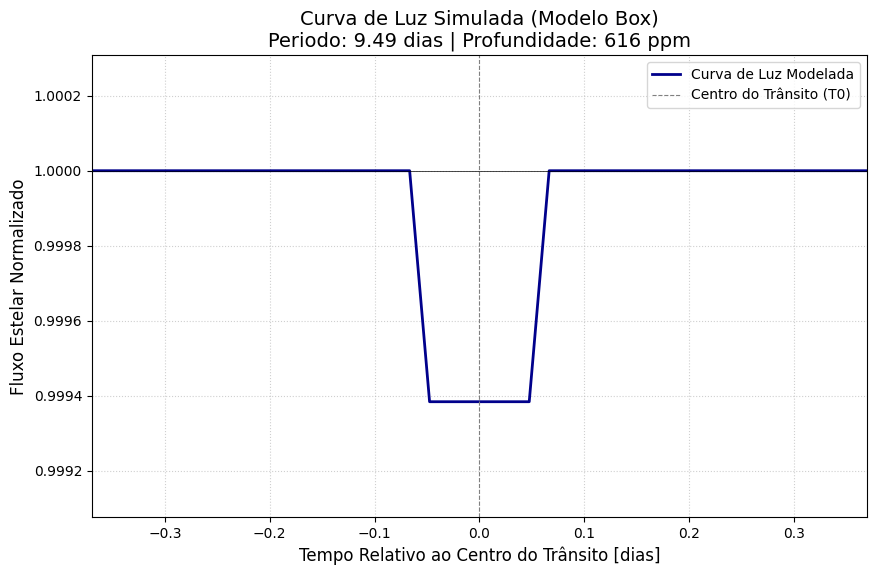


Gráfico de exemplo da curva de luz simulada salvo como 'light_curve_example.png'.
O gráfico ilustra como os 4 parâmetros chaves (Period, Epoch, Duration, Depth) se traduzem visualmente.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

FILE_NAME = 'master_clean_for_correlation.csv'

if not os.path.exists(FILE_NAME):
    print(f"AVISO: Arquivo '{FILE_NAME}' não encontrado. Usando dados sintéticos para demonstração.")
    data = {
        'period': [10.5],
        'transit_epoch_bjd': [2458000.5],
        'transit_duration_hrs': [3.5],
        'transit_depth_ppm': [1500.0],
        'planet_radius_earth': [2.1]
    }
    df_plot = pd.DataFrame(data)
else:
    df_plot = pd.read_csv(FILE_NAME)

params = df_plot.iloc[0]

PERIOD = params['period']
T0_BJD = params['transit_epoch_bjd']
DURATION_HRS = params['transit_duration_hrs']
DEPTH_PPM = params['transit_depth_ppm']

DURATION_DAYS = DURATION_HRS / 24.0
DEPTH_FRACTION = DEPTH_PPM / 1e6

phase = np.linspace(-0.5, 0.5, 500)
time_days = phase * PERIOD

transit_mask = (time_days >= -DURATION_DAYS / 2) & (time_days <= DURATION_DAYS / 2)

flux_model = np.ones_like(time_days)
flux_model[transit_mask] = 1.0 - DEPTH_FRACTION

plt.figure(figsize=(10, 6))

plt.plot(time_days, flux_model, color='darkblue', linewidth=2, label='Curva de Luz Modelada')

plt.axvline(0, color='gray', linestyle='--', linewidth=0.8, label='Centro do Trânsito (T0)')

plt.axhline(1.0, color='black', linestyle='-', linewidth=0.5)

plt.title(f'Curva de Luz Simulada (Modelo Box)\nPeriodo: {PERIOD:.2f} dias | Profundidade: {DEPTH_PPM:.0f} ppm', fontsize=14)
plt.xlabel('Tempo Relativo ao Centro do Trânsito [dias]', fontsize=12)
plt.ylabel('Fluxo Estelar Normalizado', fontsize=12)

plt.ylim(1.0 - DEPTH_FRACTION * 1.5, 1.0 + DEPTH_FRACTION * 0.5)
plt.xlim(-DURATION_DAYS * 3, DURATION_DAYS * 3)

plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.gca().ticklabel_format(useOffset=False)
plt.savefig('light_curve_example.png')
plt.show()

print("\nGráfico de exemplo da curva de luz simulada salvo como 'light_curve_example.png'.")
print("O gráfico ilustra como os 4 parâmetros chaves (Period, Epoch, Duration, Depth) se traduzem visualmente.")

In [ ]:
!pip install lightkurve

import lightkurve as lk
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 74.6 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=6fd12dbdb6d50f02413b2626e2a8d10b9002064dc0f932f814accba177967512
  Stored in directory: /root/.cache/pip/wheels/04/15/cd/2f622795b09e83471a3be5d2581cd9cf96a6ec7aa78e8deffe
  Created wheel for memoization: 

/usr/local/lib/python3.12/dist-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [ ]:
import os, json, numpy as np, pandas as pd

CSV_PATH = "/content/master_clean_for_correlation.csv"
EXPORT_DIR = "/content/web_export/tfjs_model"
os.makedirs(EXPORT_DIR, exist_ok=True)

ID_CANDIDATES = ["tic", "tic_id", "tid", "kepid", "kic", "kepoi_name", "pl_name", "hostname"]

LABEL_CANDIDATES = [
    "target_bin", "label", "is_exoplanet", "y", "class",
    "disposition","koi_disposition","koi_pdisposition","tfopwg_disp"
]

def _norm_cols(df):
    df = df.copy()
    df.columns = [str(c).strip().replace(" ", "_").replace("-", "_").lower() for c in df.columns]
    return df

def _read_one_csv(path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(path, comment="#", low_memory=False)
        if df.shape[1] <= 1:
            raise ValueError("provável header irregular")
    except Exception:
        df = pd.read_csv(path, engine="python", on_bad_lines="skip", low_memory=False)
    return _norm_cols(df)

def _get_id_cols(df):
    return [c for c in ID_CANDIDATES if c in df.columns]

def _mission_ident_row(row):
    for k in ("tic","tic_id","tid"):
        if k in row and pd.notna(row[k]):
            try: return "TESS", str(int(row[k]))
            except: return "TESS", str(row[k])
    for k in ("kepid","kic"):
        if k in row and pd.notna(row[k]):
            try: return "Kepler", str(int(row[k]))
            except: return "Kepler", str(row[k])
    return "Unknown", ""

def _make_binary_label(df: pd.DataFrame) -> pd.Series:
    """Se encontrar 'target_bin' (0/1) usa direto. Caso contrário,
       tenta inferir de colunas de disposição (CONFIRMED/FP etc)."""
    for col in ("target_bin","label","is_exoplanet","y","class"):
        if col in df.columns:
            s = df[col].copy()
            try:
                s = pd.to_numeric(s, errors="coerce")
                if set(pd.unique(s.dropna())) <= {0,1}:
                    return s.astype("Int64")
            except Exception:
                pass
            smap = {
                "confirmed":1,"confirmado":1,"pc":1,"candidate":1,"planet":1,"pos":1,"positive":1,
                "false positive":0,"fp":0,"falso_positivo":0,"no":0,"neg":0,"negative":0
            }
            try:
                return s.astype(str).str.strip().str.lower().map(smap)
            except Exception:
                pass

    def norm(x):
        if pd.isna(x): return ""
        return str(x).strip().upper()

    disp_cols = ["disposition","koi_disposition","koi_pdisposition","tfopwg_disp"]
    pos_vals  = {"CONFIRMED","CONFIRMADO","CANDIDATE","PC"}
    neg_vals  = {"FALSE POSITIVE","FP","FALSE_POSITIVE","FALSO_POSITIVO"}

    y = pd.Series([pd.NA]*len(df), index=df.index, dtype="Int64")
    for col in disp_cols:
        if col in df.columns:
            vals = df[col].map(norm)
            y = y.where(~vals.isin(pos_vals), 1)
            y = y.where(~vals.isin(neg_vals), 0)
    return y


In [ ]:
df = _read_one_csv(CSV_PATH)
print("CSV lido:", df.shape)

id_cols = _get_id_cols(df)

if "mission" not in df.columns or "ident" not in df.columns:
    mission_ident = df.apply(_mission_ident_row, axis=1, result_type="expand")
    mission_ident.columns = ["mission","ident"]
    df = pd.concat([df, mission_ident], axis=1)

y_series = _make_binary_label(df)
keep = y_series.notna()
dfy = df.loc[keep].copy()
y = y_series.loc[keep].astype(int).values

print(f"Linhas com rótulo: {len(dfy)} (de {len(df)})")

ban = set(id_cols + ["mission","ident"] + [c for c in LABEL_CANDIDATES if c in dfy.columns])
num_cols = [c for c in dfy.columns if c not in ban and np.issubdtype(dfy[c].dropna().infer_objects().dtype, np.number)]

if not num_cols:
    raise RuntimeError("Não encontrei colunas numéricas úteis para treinar. Verifique o CSV.")

X_df = dfy[num_cols].apply(pd.to_numeric, errors="coerce").astype("float32")
med = X_df.median(numeric_only=True)
X_df = X_df.fillna(med)
X = X_df.values

print("X shape:", X.shape, "| y shape:", y.shape)
print("Qtd de features:", len(num_cols))


CSV lido: (11259, 11)
Linhas com rótulo: 0 (de 11259)
X shape: (0, 9) | y shape: (0,)
Qtd de features: 9


In [ ]:
import numpy as np
import pandas as pd

def _safe_upper(x):
    try: return str(x).strip().upper()
    except: return ""

def _make_binary_label_strong(df: pd.DataFrame) -> pd.Series:
    """Cria rótulo binário 0/1 de forma bem robusta."""
    for col in ["target_bin","label","is_exoplanet","y","class"]:
        if col in df.columns:
            s = pd.to_numeric(df[col], errors="coerce")
            uniq = set(pd.unique(s.dropna()))
            if uniq <= {0,1}:
                return s.astype("Int64")

    DISPOSITION_COLS = ["disposition","koi_disposition","koi_pdisposition","tfopwg_disp","status"]
    POS = {"CONFIRMED","CONFIRMADO","CANDIDATE","PC","PLANET","YES","TRUE","POSITIVE"}
    NEG = {"FALSE POSITIVE","FP","FALSE_POSITIVE","FALSO_POSITIVO","NO","FALSE","NEGATIVE"}
    y = pd.Series([pd.NA]*len(df), index=df.index, dtype="Int64")
    for col in DISPOSITION_COLS:
        if col in df.columns:
            vals = df[col].map(_safe_upper)
            y = y.where(~vals.isin(POS), 1)
            y = y.where(~vals.isin(NEG), 0)

    if y.notna().sum() == 0:
        for col in df.columns:
            vals = df[col].astype(str).str.strip().str.lower()
            if vals.isin({"0","1","true","false","yes","no","sim","não","nao"}).mean() > 0.7:
                tmp = pd.Series([pd.NA]*len(df), dtype="Int64")
                tmp[vals.isin({"1","true","yes","sim"})] = 1
                tmp[vals.isin({"0","false","no","não","nao"})] = 0
                if tmp.notna().sum() > 0:
                    return tmp

    return y

print("Colunas candidatas a rótulo presentes no CSV:")
cands = [c for c in ["target_bin","label","is_exoplanet","y","class",
                     "disposition","koi_disposition","koi_pdisposition","tfopwg_disp","status"]
         if c in df.columns]
print(cands)
if cands:
    print("\nValores mais comuns (até 8) por coluna candidata:")
    for c in cands:
        print(f" - {c}:")
        print(df[c].astype(str).str.slice(0,40).value_counts().head(8))

need_rebuild = ('y' not in globals()) or (not isinstance(y, np.ndarray)) or (y.size == 0)
if need_rebuild:
    y_series = _make_binary_label_strong(df)
    keep = y_series.notna()
    dfy = df.loc[keep].copy()
    y = y_series.loc[keep].astype(int).values

    id_cols = [c for c in ["tic","tic_id","tid","kepid","kic","kepoi_name","pl_name","hostname","mission","ident"] if c in dfy.columns]
    ban = set(id_cols + cands)
    num_cols = [c for c in dfy.columns
                if c not in ban and pd.api.types.is_numeric_dtype(dfy[c].dropna().infer_objects())]
    if not num_cols:
        raise RuntimeError("Sem colunas numéricas para features após o filtro. Verifique o CSV.")
    X_df = dfy[num_cols].apply(pd.to_numeric, errors="coerce").astype("float32")
    X_df = X_df.fillna(X_df.median(numeric_only=True))
    X = X_df.values

print("\nResumo pós-recuperação → X:", X.shape, "| y:", y.shape)
if len(y) < 5:
    raise RuntimeError(f"Poucos exemplos rotulados ({len(y)}). "
                       "Verifique a coluna de rótulo do CSV ou ajuste o mapeamento acima.")
if len(np.unique(y)) < 2:
    raise RuntimeError("Só há uma classe no rótulo. É preciso ter 0 e 1 para treinar um classificador.")


Colunas candidatas a rótulo presentes no CSV:
[]

Resumo pós-recuperação → X: (11259, 9) | y: (11259,)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y if len(np.unique(y))>1 else None, random_state=42
)

model = keras.Sequential([
    keras.layers.Input(shape=(X.shape[1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
]

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60, batch_size=256, verbose=1,
    callbacks=callbacks
)

print("Val acc (melhor):", np.max(hist.history["val_accuracy"]))


Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7982 - loss: 0.5137 - val_accuracy: 0.6847 - val_loss: 0.5724
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9965 - loss: 0.0728 - val_accuracy: 0.9862 - val_loss: 0.1196
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 0.0312
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 0.0112
Epoch 5/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 6/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 7/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 7.9186e-04
Epoch 8/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.2376e-04 - val_accuracy: 1.0000 - 